 # Milestone 2

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

In [2]:
F1 = "D:/infosys project/archive/GlobalWeatherRepository.csv"
F2 = "D:/infosys project/archive/weather_filled.csv"
OUTPUT_DIR = "./output_milestone2"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [3]:
# Variables we'll analyze 
NUM_VARS = ["temperature_celsius", "humidity", "precip_mm", "wind_kph"]
# Columns we consider "critical" for dedupe/merge decisions
CRITICAL_TIME_COL = "last_updated"
CRITICAL_LOCATION_COLS = ["country", "location_name"]  # used for grouping/region comparison

# Extreme event thresholds 
THRESHOLDS = {
    "extreme_heat_c": 40.0,    # >40°C
    "extreme_rain_mm": 200.0,  # >200 mm
    "extreme_wind_kph": 100.0  # >100 kph
}

Load files and inspect columns

In [4]:
print("Loading files...")
df1 = pd.read_csv(F1, low_memory=False)
df2 = pd.read_csv(F2, low_memory=False)
print(f"File1 shape: {df1.shape}  |  File2 shape: {df2.shape}")

print("\nSample columns (file1):")
print(df1.columns.tolist()[:30])
print("\nSample columns (file2):")
print(df2.columns.tolist()[:30])

Loading files...
File1 shape: (88273, 41)  |  File2 shape: (135023, 41)

Sample columns (file1):
['country', 'location_name', 'latitude', 'longitude', 'timezone', 'last_updated_epoch', 'last_updated', 'temperature_celsius', 'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph', 'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'visibility_miles', 'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide']

Sample columns (file2):
['country', 'location_name', 'latitude', 'longitude', 'timezone', 'last_updated_epoch', 'last_updated', 'temperature_celsius', 'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph', 'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 

Join strategy

In [5]:
common_cols = set(df1.columns).intersection(df2.columns)
overlap_ratio = len(common_cols) / max(len(df1.columns), len(df2.columns))
print(f"\nCommon columns: {len(common_cols)} | Overlap ratio: {overlap_ratio:.2f}")

if overlap_ratio >= 0.7:
    print("Schemas mostly match → concatenating rows.")
    merged = pd.concat([df1, df2], ignore_index=True, sort=False)
    # Remove exact duplicate rows (if any)
    before = merged.shape[0]
    merged = merged.drop_duplicates()
    after = merged.shape[0]
    print(f"Concatenated shape: {merged.shape}  (deduped {before-after} rows)")
else:
    # fallback: outer merge on time+location if available
    print("Schemas differ — attempting merge on time+location keys.")
    possible_time = [c for c in common_cols if "last_updated" in c.lower() or "date" in c.lower()]
    possible_loc = [c for c in common_cols if c.lower() in ("country", "location_name", "city", "station")]
    print("Detected time cols:", possible_time, "location cols:", possible_loc)
    if "last_updated" in common_cols and "location_name" in common_cols:
        merged = pd.merge(df1, df2, on=["last_updated", "location_name"], how="outer", suffixes=("_1","_2"))
    elif "last_updated" in common_cols and "country" in common_cols:
        merged = pd.merge(df1, df2, on=["last_updated", "country"], how="outer", suffixes=("_1","_2"))
    else:
        # Last resort: concat with indicator so you can inspect afterward
        merged = pd.concat([df1, df2], ignore_index=True, sort=False)
    print("Merged shape:", merged.shape)


Common columns: 41 | Overlap ratio: 1.00
Schemas mostly match → concatenating rows.
Concatenated shape: (135023, 41)  (deduped 88273 rows)


Normalize column names: ensure numeric fields exist


In [6]:
for col in NUM_VARS:
    if col not in merged.columns:
        print(f"Warning: column '{col}' not found in merged dataset — it may be named differently. You may need to rename it.")
# Quick cast-to-numeric for numeric-looking columns (coerce errors)
for col in NUM_VARS:
    if col in merged.columns:
        merged[col] = pd.to_numeric(merged[col], errors="coerce")


Parse datetime and create year_month (timestamp at first day of month)

In [7]:
if CRITICAL_TIME_COL in merged.columns:
    merged[CRITICAL_TIME_COL] = pd.to_datetime(merged[CRITICAL_TIME_COL], errors="coerce")
else:
    # attempt to find any datetime-like column
    for c in merged.columns:
        if "date" in c.lower() or "time" in c.lower():
            merged[c] = pd.to_datetime(merged[c], errors="coerce")
            CRITICAL_TIME_COL = c
            print(f"Using detected time column: {CRITICAL_TIME_COL}")
            break

merged["year_month"] = merged[CRITICAL_TIME_COL].dt.to_period("M").dt.to_timestamp()
print(f"\nDatetime parse: {CRITICAL_TIME_COL} -> year_month populated (nulls: {merged['year_month'].isna().sum()})")


Datetime parse: last_updated -> year_month populated (nulls: 0)


Basic cleaning

In [8]:
drop_condition = merged["year_month"].isna() & merged["country"].isna()
dropped = drop_condition.sum()
if dropped > 0:
    merged = merged[~drop_condition].copy()
    print(f"Dropped {dropped} rows without time & country")


Save merged raw file for reproducibility

In [9]:
merged_path = os.path.join(OUTPUT_DIR, "merged_full.csv")
merged.to_csv(merged_path, index=False)
print(f"Saved merged file: {merged_path}  (shape: {merged.shape})")


Saved merged file: ./output_milestone2\merged_full.csv  (shape: (135023, 42))


Create monthly aggregated DataFrame for analysis (numeric average by year_month & country)


In [10]:
monthly_df = (
    merged.groupby(["year_month", "country"], dropna=False)
    .agg({c: "mean" for c in NUM_VARS})
    .reset_index()
)

monthly_df_path = os.path.join(OUTPUT_DIR, "monthly_agg_by_country.csv")
monthly_df.to_csv(monthly_df_path, index=False)
print(f"Saved monthly aggregated data: {monthly_df_path}  (shape: {monthly_df.shape})")


Saved monthly aggregated data: ./output_milestone2\monthly_agg_by_country.csv  (shape: (4836, 6))


# ANALYTICAL STEPS


Descriptive statistics & distributions


Descriptive stats (numeric vars):
                        count       mean        std   min   25%   50%    75%  \
temperature_celsius  135023.0  21.692591   9.679223 -41.9  16.1  24.2  28.20   
humidity             135023.0  65.749694  23.497649   2.0  50.0  71.0  84.00   
precip_mm            135023.0   0.138510   0.602553   0.0   0.0   0.0   0.02   
wind_kph             135023.0  12.955092  11.671252   3.6   6.1  11.2  17.60   

                         max  
temperature_celsius    49.20  
humidity              100.00  
precip_mm              42.24  
wind_kph             2963.20  


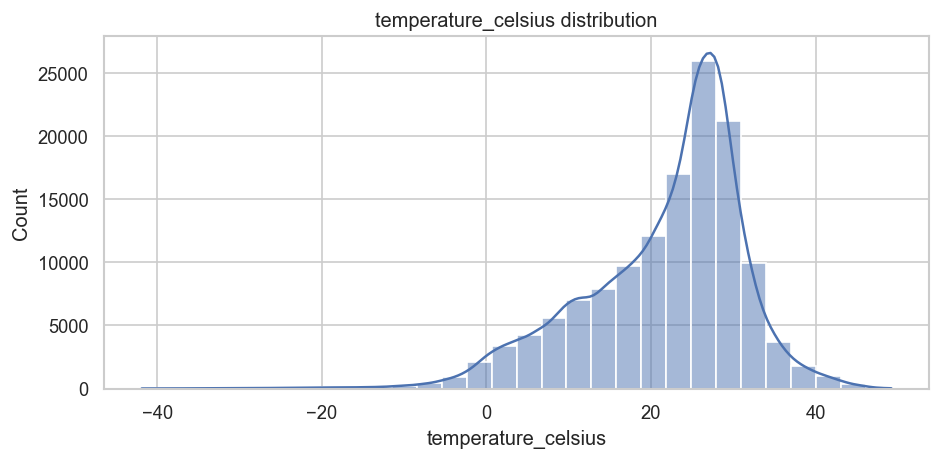

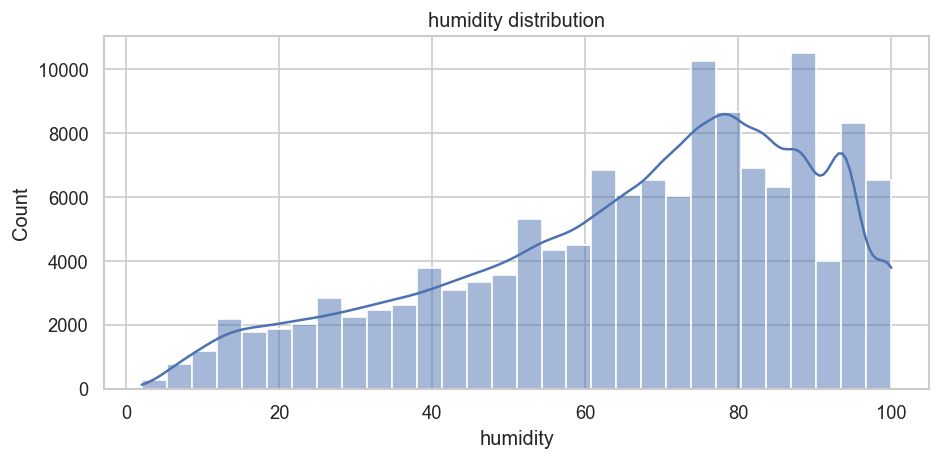

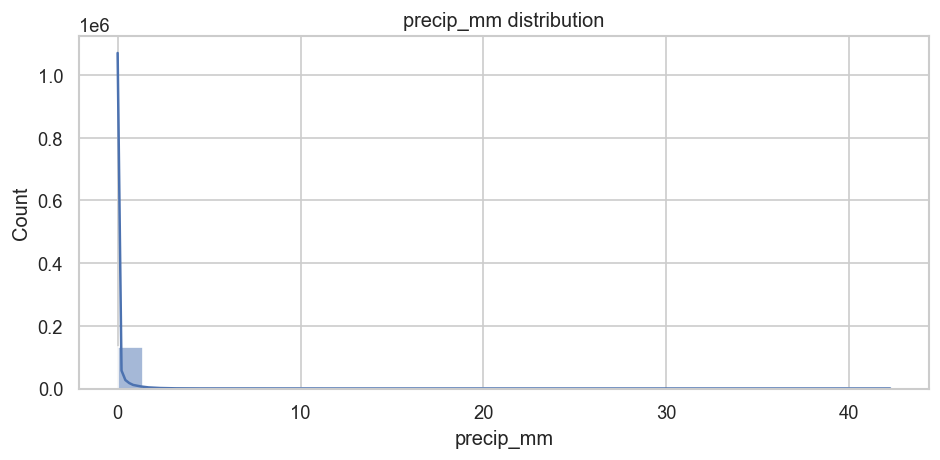

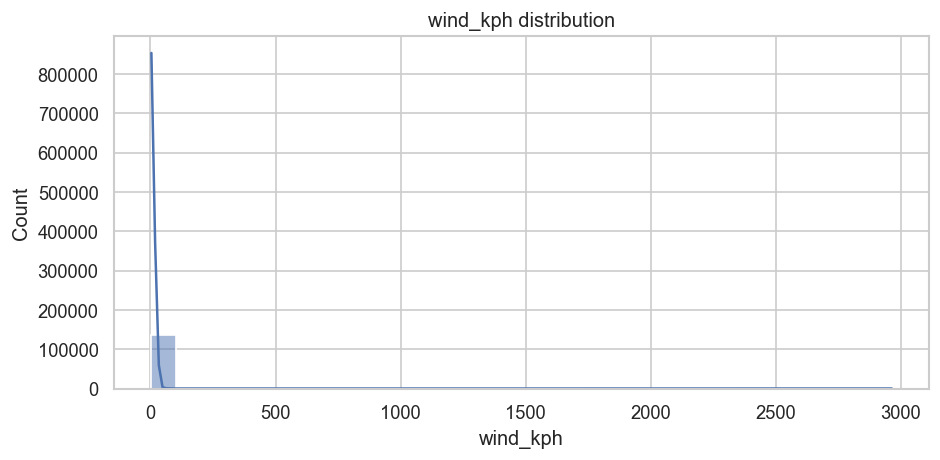

In [11]:
desc = merged[NUM_VARS].describe().T
print("\nDescriptive stats (numeric vars):")
print(desc)

# Save description
desc.to_csv(os.path.join(OUTPUT_DIR, "numeric_descriptive_stats.csv"))

# Create and show distribution plots
def save_hist(col, df=merged, outdir=OUTPUT_DIR, bins=30):
    if col not in df.columns:
        return
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), bins=bins, kde=True)
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

for v in NUM_VARS:
    save_hist(v)

Correlation matrix (on numeric variables)

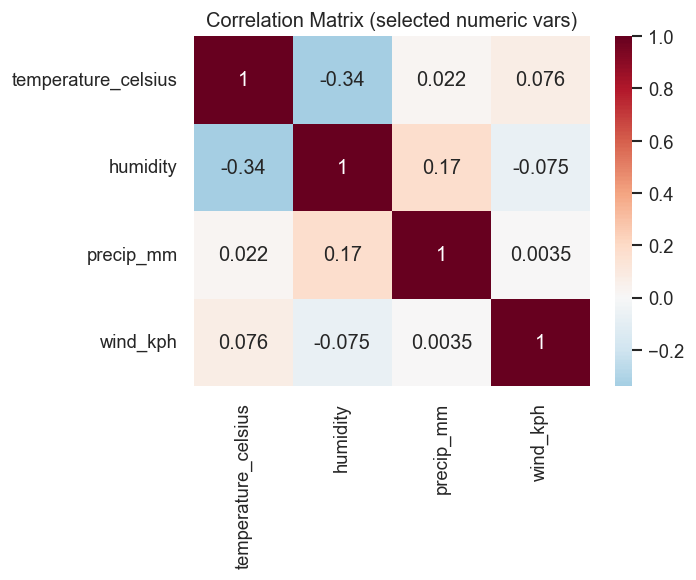

In [12]:
corr = merged[NUM_VARS].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="RdBu_r", center=0)
plt.title("Correlation Matrix (selected numeric vars)")
plt.tight_layout()
plt.show()
corr.to_csv(os.path.join(OUTPUT_DIR, "correlation_values.csv"))



Seasonal trends (global averages)

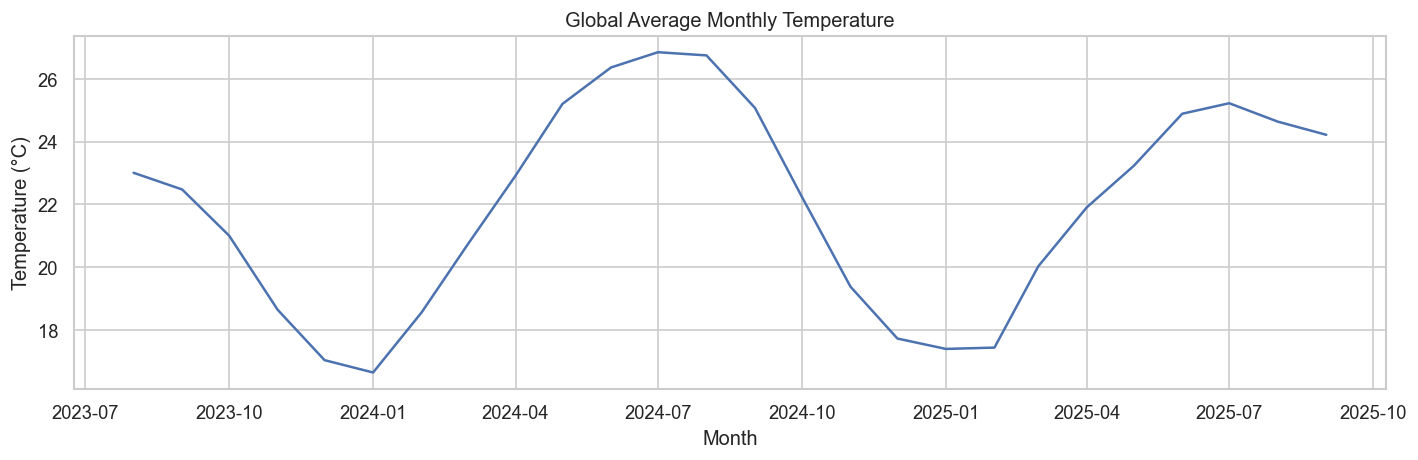

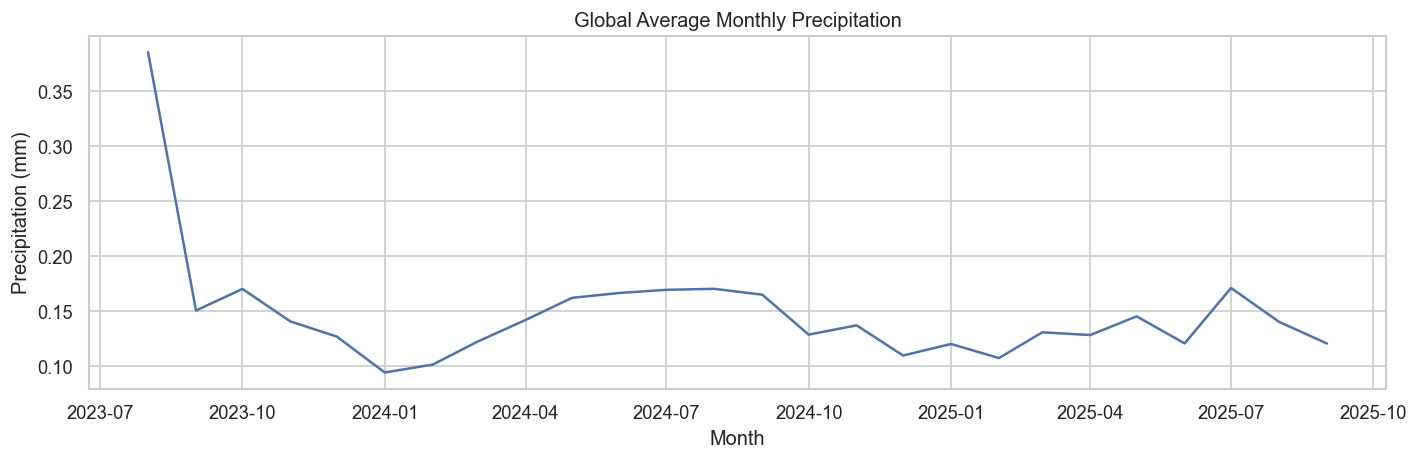

In [13]:
monthly_trends = monthly_df.groupby("year_month")[NUM_VARS].mean().reset_index()

# Temperature trend
plt.figure(figsize=(12,4))
sns.lineplot(data=monthly_trends, x="year_month", y="temperature_celsius")
plt.title("Global Average Monthly Temperature")
plt.xlabel("Month"); plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.show()

# Precipitation trend
if "precip_mm" in monthly_trends.columns:
    plt.figure(figsize=(12,4))
    sns.lineplot(data=monthly_trends, x="year_month", y="precip_mm")
    plt.title("Global Average Monthly Precipitation")
    plt.xlabel("Month"); plt.ylabel("Precipitation (mm)")
    plt.tight_layout()
    plt.show()



Extreme event detection (on merged rows, not aggregated)



Extreme events counts:
Heat: 1372 Rain: 0 Wind: 7


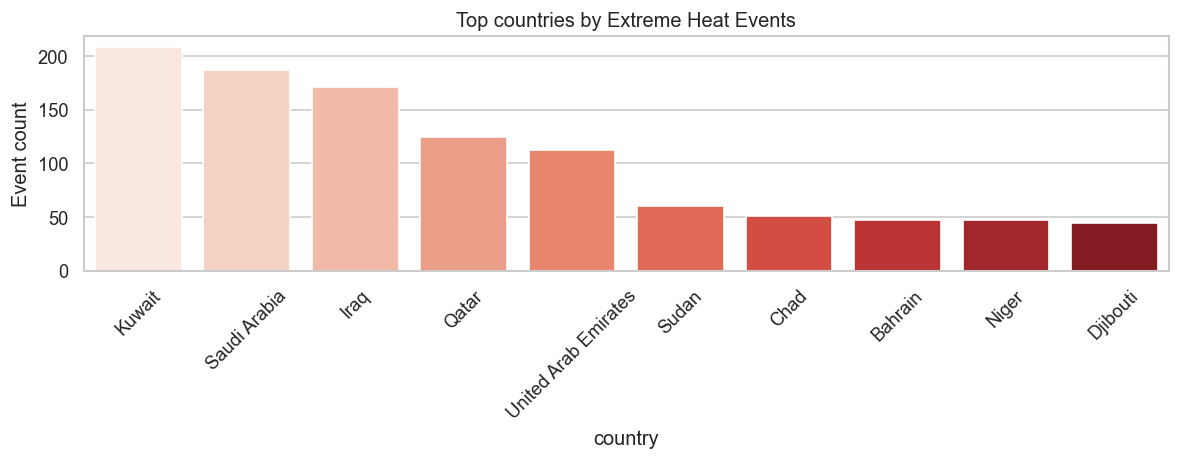

In [14]:
extreme_heat = merged[merged["temperature_celsius"] > THRESHOLDS["extreme_heat_c"]]
extreme_rain = merged[merged["precip_mm"] > THRESHOLDS["extreme_rain_mm"]]
extreme_wind = merged[merged["wind_kph"] > THRESHOLDS["extreme_wind_kph"]]

print("\nExtreme events counts:")
print("Heat:", len(extreme_heat), "Rain:", len(extreme_rain), "Wind:", len(extreme_wind))

# Save summary csvs
extreme_heat.to_csv(os.path.join(OUTPUT_DIR, "extreme_heat_events.csv"), index=False)
extreme_rain.to_csv(os.path.join(OUTPUT_DIR, "extreme_rain_events.csv"), index=False)
extreme_wind.to_csv(os.path.join(OUTPUT_DIR, "extreme_wind_events.csv"), index=False)


# Plot top countries for extreme heat
if not extreme_heat.empty:
    top_heat = extreme_heat["country"].value_counts().head(10)
    plt.figure(figsize=(10,4))
    sns.barplot(x=top_heat.index, y=top_heat.values, hue=top_heat.index, palette="Reds", legend=False)
    plt.title("Top countries by Extreme Heat Events")
    plt.xticks(rotation=45)
    plt.ylabel("Event count")
    plt.tight_layout()
    plt.show()


Regional comparisons: avg by country (overall averages)

In [15]:
country_avg = merged.groupby("country")[NUM_VARS].mean().reset_index()
country_avg_path = os.path.join(OUTPUT_DIR, "country_level_averages.csv")
country_avg.to_csv(country_avg_path, index=False)
print("Saved:", country_avg_path)

Saved: ./output_milestone2\country_level_averages.csv


Top 10 hottest countries (by avg temp)

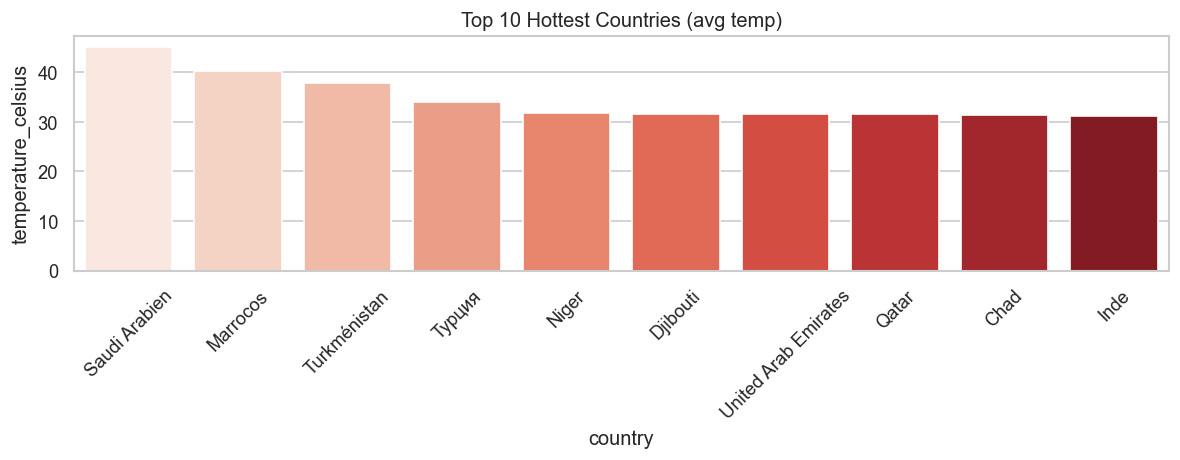

In [16]:
if "temperature_celsius" in country_avg.columns:
    top10 = country_avg.sort_values("temperature_celsius", ascending=False).head(10)
    plt.figure(figsize=(10,4))
    sns.barplot(data=top10, x="country", y="temperature_celsius", hue="country", palette="Reds", legend=False)
    plt.title("Top 10 Hottest Countries (avg temp)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


 Seasonal heatmap (country x month) — be careful, this can be large; limit to top countries

 choose a small set of countries for visualization (top 12 by records)

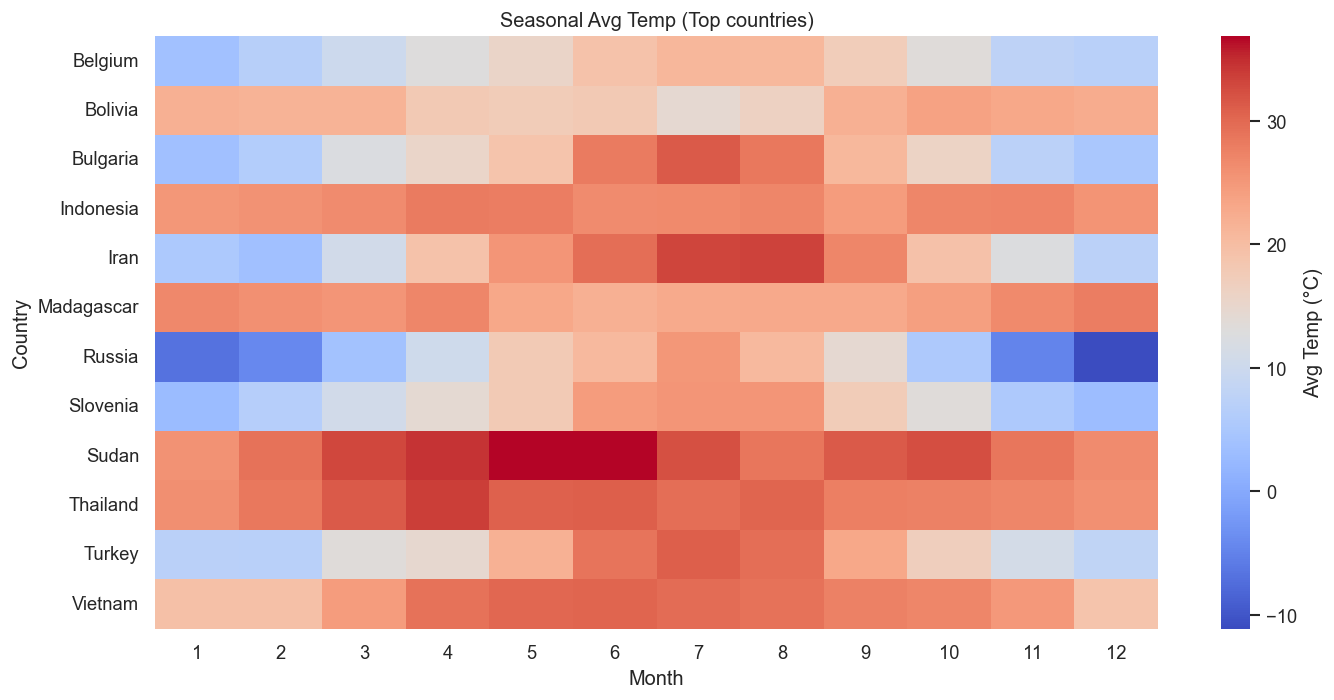

In [17]:
top_countries_by_records = merged["country"].value_counts().head(12).index.tolist()
seasonal = merged[merged["country"].isin(top_countries_by_records)].copy()
seasonal["month"] = seasonal["year_month"].dt.month
pivot = seasonal.groupby(["country","month"])["temperature_celsius"].mean().unstack(level=0).T.fillna(np.nan)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="coolwarm", cbar_kws={"label":"Avg Temp (°C)"})
plt.title("Seasonal Avg Temp (Top countries)")
plt.xlabel("Month"); plt.ylabel("Country")
plt.tight_layout()
plt.show()


Generate basic report skeleton (Markdown)

In [21]:
report_md = os.path.join(OUTPUT_DIR, "Milestone2_report.md")
with open(report_md, "w", encoding="utf-8") as f:
    f.write("# ClimateScope — Milestone 2 Report\n\n")
    f.write("## 1. Summary\n")
    f.write(f"- Merged dataset shape: {merged.shape}\n")
    f.write(f"- Monthly aggregated shape: {monthly_df.shape}\n\n")
    f.write("## 2. Descriptive statistics\n")
    f.write("- See `numeric_descriptive_stats.csv` and the plots in the `output_milestone2` folder.\n\n")
    f.write("## 3. Key Findings (fill in after visual review)\n")
    f.write("- Observations about distributions, correlations, and seasonal trends.\n\n")
    f.write("## 4. Extreme events\n")
    f.write("- Lists saved: `extreme_heat_events.csv`, `extreme_rain_events.csv`, `extreme_wind_events.csv`.\n\n")
    f.write("## 5. Visuals\n")
    f.write("- Temperature distribution: temperature_celsius_distribution.png\n")
    f.write("- Correlation matrix: correlation_matrix.png\n")
    f.write("- Global monthly trends: global_monthly_temperature_trend.png, global_monthly_precip_trend.png\n")
    f.write("- Top countries visuals and seasonal heatmap saved as PNGs in this folder.\n\n")
    f.write("## 6. Dashboard wireframe\n")
    f.write("- Sketch an interactive dashboard: choropleth world map, trend selectors, region filters, extreme-event panel.\n")

print("Report skeleton saved:", report_md)

print("\n*** Milestone 2 data prep & analysis complete. Check the folder:", OUTPUT_DIR, "for CSVs and PNGs. ***")

Report skeleton saved: ./output_milestone2\Milestone2_report.md

*** Milestone 2 data prep & analysis complete. Check the folder: ./output_milestone2 for CSVs and PNGs. ***


In [20]:
# Final concluding statement
print("\n***************************************************************")
print("Milestone 2: Core Analysis and Visualization Design is complete.")
print("All analytical tasks, data preparations, and visualizations have been executed.")
print("The generated plots and CSV files are available in the 'output_milestone2' folder.")
print("Ready to begin Milestone 3: Visualization Development & Interactivity.")
print("***************************************************************")


***************************************************************
Milestone 2: Core Analysis and Visualization Design is complete.
All analytical tasks, data preparations, and visualizations have been executed.
The generated plots and CSV files are available in the 'output_milestone2' folder.
Ready to begin Milestone 3: Visualization Development & Interactivity.
***************************************************************
